# 03 - Modelo de Machine Learning: Clasificación de Sentimientos

Este notebook aplica un **modelo de Machine Learning (Random Forest)** para clasificar el sentimiento de posts en redes sociales.

**Dataset:** SocialBuzz Sentiment Analytics (732 muestras)

**Target:** Sentimiento agrupado en 3 clases: `Positivo`, `Neutro`, `Negativo`

**Features:** TF-IDF sobre texto + features numéricas (Retweets, Likes, Year, Month, Day, Hour)

## 0) Instalación e importación de librerías

In [7]:
try:
    import kagglehub
except ImportError:
    import subprocess
    subprocess.run(['pip', 'install', 'kagglehub', '-q'])
    import kagglehub

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
from scipy.sparse import hstack, csr_matrix
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42


## 1) Carga de datos

In [9]:
#Cargamos datos desde kagglehub:
path = kagglehub.dataset_download('eshummalik/socialbuzz-sentiment-analytics')
file_path = os.path.join(path, 'sentimentdataset.csv')
df = pd.read_csv(file_path)

print(f'Shape: {df.shape}')
df.head(3)

Using Colab cache for faster access to the 'socialbuzz-sentiment-analytics' dataset.
Shape: (732, 15)


,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15


## 2) Preprocesado

In [10]:
#Limpiamos texto y sentimiento:
df['Text'] = df['Text'].astype(str).str.strip()
df['Sentiment'] = df['Sentiment'].astype(str).str.strip()

#Mapeamos los sentimientos a 3 clases:
POSITIVE_EMOTIONS = {
    'Joy', 'Positive', 'Happiness', 'Happy', 'Excitement', 'Elation', 'Euphoria',
    'Love', 'Gratitude', 'Contentment', 'Optimism', 'Hope', 'Hopeful', 'Satisfaction',
    'Pride', 'Proud', 'Amusement', 'Awe', 'Inspiration', 'Inspired', 'Enthusiasm',
    'Confidence', 'Confident', 'Empowerment', 'Freedom', 'Courage', 'Determination',
    'Accomplishment', 'Celebration', 'Serenity', 'Tranquility', 'Peace', 'Calmness',
    'Positivity', 'Blessed', 'Warmth', 'Heartwarming', 'Tenderness', 'Affection',
    'Admiration', 'Adoration', 'Amazement', 'Wonder', 'Wonderment', 'Enchantment',
    'Captivation', 'Marvel', 'Charm', 'Playful', 'PlayfulJoy', 'FestiveJoy',
    'JoyfulReunion', 'Overjoyed', 'Ecstasy', 'Triumph', 'Success', 'Fulfillment',
    'Appreciation', 'Relieved', 'Relief', 'Kindness', 'Kind',
    'Compassion', 'Compassionate', 'Sympathy', 'Empathetic', 'Friendship', 'Romance',
    'Connection', 'Harmony', 'Radiance', 'Zest', 'Energy', 'Vibrancy', 'Spark',
    'Breakthrough', 'Motivation', 'Resilience', 'Adventure', 'Exploration',
    'Curiosity', 'Imagination', 'Creativity', 'Creative Inspiration', 'ArtisticBurst',
    'Grateful', 'Rejuvenation', 'Journey', 'Mindfulness', 'Solace', 'Touched',
    'Acceptance', 'Bittersweet', 'Whimsy', 'Free-spirited',
    'Dazzle', 'Hypnotic', 'Mesmerizing', 'Iconic', 'Melodic', 'Grandeur',
    'Reverence', 'Anticipation', 'Thrill', 'Thrilling Journey', 'Immersion',
    'Engagement', 'Colorful', 'Elegance', 'Runway Creativity',
    'CulinaryOdyssey', 'Culinary Adventure', 'Joy in Baking', 'Adrenaline',
    "Nature's Beauty", "Ocean's Freedom", 'Celestial Wonder', 'Envisioning History',
    'Winter Magic', 'Whispers of the Past', 'Ruins', 'Enjoyment', 'Intrigue',
    'DreamChaser', 'InnerJourney', 'Arousal',
}

NEGATIVE_EMOTIONS = {
    'Negative', 'Sadness', 'Sad', 'Anger', 'Fear', 'Fearful', 'Despair', 'Desperation',
    'Grief', 'Sorrow', 'Heartbreak', 'Heartache', 'LostLove', 'Loss', 'Loneliness',
    'Isolation', 'Disappointment', 'Disappointed', 'Regret', 'Guilt', 'Shame',
    'Frustration', 'Frustrated', 'Hate', 'Resentment', 'Envy', 'Envious',
    'Jealousy', 'Jealous', 'Disgust', 'Betrayal', 'Bitterness', 'Bitter', 'Bad',
    'Desolation', 'Darkness', 'Suffering', 'Helplessness', 'Devastated', 'Overwhelmed',
    'Anxiety', 'Apprehensive', 'Pressure', 'Exhaustion', 'Numbness', 'Melancholy',
    'Pensive', 'Obstacle', 'Miscalculation', 'Intimidation', 'Dismissive',
    'EmotionalStorm', 'Mischievous',
}

NEUTRAL_EMOTIONS = {
    'Neutral', 'Indifference', 'Nostalgia', 'Reflection', 'Contemplation',
    'Ambivalence', 'Surprise', 'Confusion', 'Suspense', 'Yearning', 'Solitude',
    'Coziness', 'Embarrassed', 'Embarrassment',
}

def map_sentiment(sent):
    if sent in POSITIVE_EMOTIONS:
        return 'Positivo'
    elif sent in NEGATIVE_EMOTIONS:
        return 'Negativo'
    elif sent in NEUTRAL_EMOTIONS:
        return 'Neutro'
    else:
        pos_keywords = ['joy', 'happy', 'love', 'hope', 'good', 'great', 'excit', 'wonder',
                        'posit', 'glad', 'cheer', 'bright', 'amaz', 'thrill', 'bliss']
        neg_keywords = ['sad', 'bad', 'hate', 'fear', 'angry', 'angr', 'grief', 'depress',
                        'negat', 'despair', 'pain', 'sorrow', 'hurt', 'rage', 'bitter']
        s_lower = sent.lower()
        for kw in pos_keywords:
            if kw in s_lower:
                return 'Positivo'
        for kw in neg_keywords:
            if kw in s_lower:
                return 'Negativo'
        return 'Neutro'

df['sentiment_group'] = df['Sentiment'].apply(map_sentiment)

print('Distribución de clases agrupadas:')
print(df['sentiment_group'].value_counts())

Distribución de clases agrupadas:
sentiment_group
Positivo    474
Negativo    175
Neutro       83
Name: count, dtype: int64


In [11]:
le = LabelEncoder()
y = le.fit_transform(df['sentiment_group'])
print(f'Clases: {le.classes_}')

num_features = ['Retweets', 'Likes', 'Year', 'Month', 'Day', 'Hour']
X_num  = df[num_features].fillna(0).values
X_text = df['Text'].values

#División 70/15/15
X_text_train, X_text_temp, X_num_train, X_num_temp, y_train, y_temp = train_test_split(
    X_text, X_num, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)
X_text_val, X_text_test, X_num_val, X_num_test, y_val, y_test = train_test_split(
    X_text_temp, X_num_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)

#TF-IDF
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 2), sublinear_tf=True)
X_tfidf_train = tfidf.fit_transform(X_text_train)
X_tfidf_val   = tfidf.transform(X_text_val)
X_tfidf_test  = tfidf.transform(X_text_test)

#Combinamos features
X_train = hstack([X_tfidf_train, csr_matrix(X_num_train)])
X_val   = hstack([X_tfidf_val,   csr_matrix(X_num_val)])
X_test  = hstack([X_tfidf_test,  csr_matrix(X_num_test)])

print(f'Train: {len(y_train)} | Val: {len(y_val)} | Test: {len(y_test)}')
print(f'Dimensión de features: {X_train.shape[1]}')

Clases: ['Negativo' 'Neutro' 'Positivo']
Train: 512 | Val: 110 | Test: 110
Dimensión de features: 506


## 3) Modelo ML: Random Forest

In [12]:
#Entrenamos Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)

#Número de parámetros
n_nodes = sum(tree.tree_.node_count for tree in rf.estimators_)

print(f'Total de árboles: {rf.n_estimators}')
print(f'Total de parámetros del modelo: {n_nodes:,}')

Total de árboles: 100
Total de parámetros del modelo: 5,236


## 4) Evaluación en Train, Validación y Test

In [14]:
def evaluate(model, X, y_true, split_name, class_names):
    y_pred = model.predict(X)

    acc  = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)

    print(f'\n=== {split_name} ===')
    print(f'Accuracy: {acc:.4f}')
    print(f'F1-Macro: {f1:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall: {rec:.4f}')
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    return acc, f1, prec, rec

class_names = le.classes_

acc_train, f1_train, prec_train, rec_train = evaluate(rf, X_train, y_train, 'TRAIN', class_names)
acc_val, f1_val, prec_val, rec_val = evaluate(rf, X_val, y_val, 'VALIDACIÓN', class_names)
acc_test, f1_test, prec_test, rec_test = evaluate(rf, X_test, y_test, 'TEST', class_names)


=== TRAIN ===
Accuracy: 0.8105
F1-Macro: 0.6839
Precision: 0.9201
Recall: 0.6174
              precision    recall  f1-score   support

    Negativo       0.98      0.52      0.68       122
      Neutro       1.00      0.33      0.49        58
    Positivo       0.78      1.00      0.87       332

    accuracy                           0.81       512
   macro avg       0.92      0.62      0.68       512
weighted avg       0.85      0.81      0.79       512


=== VALIDACIÓN ===
Accuracy: 0.6818
F1-Macro: 0.3563
Precision: 0.5566
Recall: 0.3846
              precision    recall  f1-score   support

    Negativo       1.00      0.15      0.27        26
      Neutro       0.00      0.00      0.00        13
    Positivo       0.67      1.00      0.80        71

    accuracy                           0.68       110
   macro avg       0.56      0.38      0.36       110
weighted avg       0.67      0.68      0.58       110


=== TEST ===
Accuracy: 0.7455
F1-Macro: 0.5068
Precision: 0.8779
Rec

## 5) Importancia de features

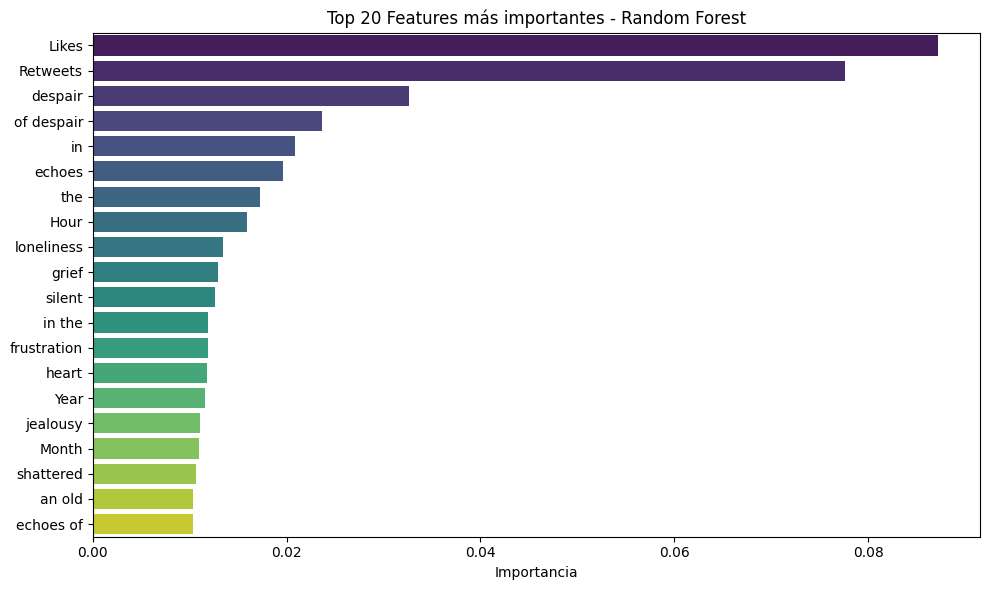

In [15]:
feature_names = tfidf.get_feature_names_out().tolist() + num_features
importances   = rf.feature_importances_

top_n = 20
top_idx = np.argsort(importances)[::-1][:top_n]
top_features = [feature_names[i] for i in top_idx]
top_importances = importances[top_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette='viridis')
plt.title(f'Top {top_n} Features más importantes - Random Forest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

## 6) Matriz de confusión (Test)

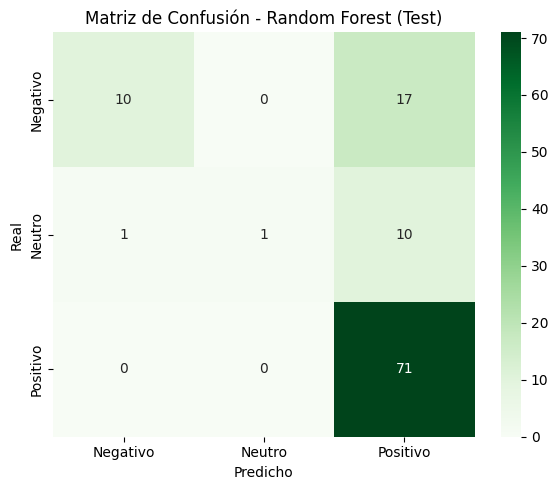

In [18]:
y_pred_test = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - Random Forest (Test)')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

## 7) Resumen de Resultados

In [20]:
results = pd.DataFrame({
    'Split': ['Train', 'Validación', 'Test'],
    'Accuracy': [acc_train, acc_val, acc_test],
    'F1-Macro': [f1_train, f1_val, f1_test],
    'Precisión': [prec_train, prec_val, prec_test],
    'Recall': [rec_train, rec_val, rec_test],
})

results = results.round(4)

print("\n=== RESUMEN MODELO Random Forest ===")
print(f"Número de parámetros: {n_nodes:,}")
print(results.to_string(index=False))

print("\nTabla:")
print(f"| Random Forest | {n_nodes:,} | "
      f"{acc_train:.4f} | {acc_val:.4f} | {acc_test:.4f} | "
      f"{f1_train:.4f} | {f1_val:.4f} | {f1_test:.4f} | "
      f"{prec_train:.4f} | {prec_val:.4f} | {prec_test:.4f} | "
      f"{rec_train:.4f} | {rec_val:.4f} | {rec_test:.4f} |")


=== RESUMEN MODELO Random Forest ===
Número de parámetros: 5,236
     Split  Accuracy  F1-Macro  Precisión  Recall
     Train    0.8105    0.6839     0.9201  0.6174
Validación    0.6818    0.3563     0.5566  0.3846
      Test    0.7455    0.5068     0.8779  0.4846

Tabla:
| Random Forest | 5,236 | 0.8105 | 0.6818 | 0.7455 | 0.6839 | 0.3563 | 0.5068 | 0.9201 | 0.5566 | 0.8779 | 0.6174 | 0.3846 | 0.4846 |
